# Topic Model

### We need to set up our environment. The following libraries have been used:

 - Gensim
 - matplotlib
 - spaCy
 - pyLDAVis

Please un-comment and install following libraries

In [1]:
#!pip install gensim
#!pip install spacy
#!pip install pyldavis

#!python -m spacy download en

In [2]:
import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import os, re, operator, warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Download spacy en_core_web_sm which is a pre-trained statistical models for English

In [3]:
nlp = spacy.load("en")

### I have used Amazon AWS Sagemaker for this whole setup. We need some required libraries to load data through S3.

### To load the data from S3 please uncomment the following lines

In [76]:
#import boto3
#import pandas as pd
#from sagemaker import get_execution_role

#role = get_execution_role()


In [77]:
#bucket='aws-lambda-trigger-pan' #You-Bucket-Name-in-S3
#data_key = 'articles1.csv' #filename
#data_location = 's3://{}/{}'.format(bucket, data_key)

### To load the data from local system please uncomment and provide the name and location of the file.

In [61]:
## data_location = {location of dataset}

In [6]:
art1 = pd.read_csv(data_location)

In [7]:
art1.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


### Let's get an idea about different values in columns

In [8]:
art1.groupby('publication').count()[['content']]

,content
publication,
Atlantic,171
Breitbart,23781
Business Insider,6757
CNN,11488
New York Times,7803


Let's break down table with publication names to extract exclusive contents. We can achieve without breaking the table but we can go step wise and cleaner this way.

In [9]:
atlantic = art1[art1['publication']=='Atlantic']
breitbart = art1[art1['publication']=='Breitbart']
business = art1[art1['publication']=='Business Insider']
cnn = art1[art1['publication']=='CNN']
nyt = art1[art1['publication']=='New York Times']

In [10]:
publishers = art1['publication'].unique()

Lets pick one article per author and Let's only put first document of the author. This way we will be mostly using 10% of all data set which wil mmake development fatser. We can use whole datset once we are finish the final structure of our model and we wont be losing much information since most of the author are mostly subject matter experts and write on similar topics most of the time.

## We will proceed with above assumption

In [11]:
unique_author_doc = {}

def get_unique_author_docs(publication):
    unique_doc = {}
    pub = art1[art1['publication']==publication]
    for index, row in pub.iterrows():
        if row['author'] not in unique_author_doc:
            unique_doc[row['author']]=row['content']
    
    return unique_doc
    

In [12]:
for publisher in publishers:
    print(publisher)
    auth_dict = get_unique_author_docs(publisher)
    unique_author_doc.update(auth_dict)
    

New York Times
Breitbart
CNN
Business Insider
Atlantic


In [13]:
len(unique_author_doc)

3604

#### We can now start our exploration with 3604 records

In [14]:
unique_contents = unique_author_doc.values()

#### Saving data at some interval can save our time in rerun our debuggig the code

In [15]:
import pickle

#with open('unique_contents_pickle.pkl', 'wb') as pickle_out:  
#    pickle.dump(unique_contents, pickle_out)

In [16]:
#with open('unique_contents_pickle.pkl', 'rb') as pickle_in:  
#    unpickled_list = pickle.load(pickle_in)

#print(unpickled_list)  

In [17]:
#unique_contents = unpickled_list

#### We can make use of Spacy's stopwords

In [18]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [19]:
len(spacy_stopwords)

326

#### I am using some custom stopwords based on my observation

In [20]:
my_stop_words = [u'mr.',u'mr',u'd._n.',u'd.',
                 u'c.',u'mrs',u'Mrs.',u'Mrs',u'obama',u'clinton',u'people',u'trump',u'castro',u'pic'
                ,u'like',u'work',u'come',u'know',u'new',u'way',u'want',u'think',u'include',u'come',u'tell',
                 u'write',u'irs',u'use',u'build',u'believe',u'say', u'\'s', u'Mr', u'be', u'said', u'says', u'saying']

In [21]:
for s in my_stop_words:
    spacy_stopwords.add(s)


In [22]:
len(spacy_stopwords)

359

In [23]:
for stopword in spacy_stopwords:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

#### We can preprocess the data to get clean data

In [24]:
import re

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = spacy_stopwords

def text_prepare(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwors from text
    text = text.strip()
    return text

#### Applying above method on data

In [25]:
pre_docs = []
for content in unique_contents:
    doc = text_prepare(content)
    pre_docs.append(doc)

#### Using sapcy to create nlp object

In [26]:
docs = []
for content in pre_docs:
    doc = nlp(content)
    docs.append(doc)

In [27]:
with open('topic_2.0/nlp_docs.pkl', 'wb') as pickle_out:
    pickle.dump(docs, pickle_out)

In [28]:
with open('topic_2.0/nlp_docs.pkl', 'rb') as pickle_in:  
    unpickled_nlp_docs = pickle.load(pickle_in)

#print(unpickled_list)  
docs=unpickled_nlp_docs

#### Finally create usable text after lemmatization and removing numbers and stopwords

In [29]:
# we add some words to the stop word list
texts, article = [], []
for doc in docs:
    for w in doc:
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text)>2:
            lem = w.lemma_
            if(len(lem)>2):
                if lem not in STOPWORDS:
                    article.append(lem)
        
    texts.append(article)
    article = []

In [30]:
#with open('topic_2.0/nlp_texts.pkl', 'wb') as pickle_out:
#    pickle.dump(texts, pickle_out)

In [31]:
#with open('topic_2.0/nlp_texts.pkl', 'rb') as pickle_in:  
#    unpickled_texts = pickle.load(pickle_in)

#print(unpickled_list)  

In [32]:
#texts = unpickled_texts

#### We can create bi-grams of texts appropriately. I don't find much usefull but with the complete dataset it may make sense. 
##### So it is optional

In [33]:

bigram = gensim.models.Phrases(texts)
texts = [bigram[line] for line in texts]


#### Create corpus with usable texts to fed into model

In [34]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

We can use following open source implementation of the models that are readily available for topic modeling
---

- Latent Semantic Indexing / Latent Semantic Analysis
    
- Latent Dirichlet Allocation (LDA)
    
- Hierarchical Dirichlet Process (HDP)
    
    

## Let's start with LSI

LSI stands for Latent Semantic Indeixing - it is a popular information retreival method which works by decomposing the original matrix of words to maintain key topics. Gensim's implementation uses an SVD.

#### As we have taken small corpus out of big dataset. We can start with 5 topics to make a relevant assumption

In [35]:
lsimodel = LsiModel(corpus=corpus, num_topics=5, id2word=dictionary)
lsimodel.show_topics(num_topics=5)

[(0,
  '0.201*"time" + 0.199*"year" + 0.126*"day" + 0.122*"tell" + 0.120*"state" + 0.118*"american" + 0.117*"president" + 0.116*"company" + 0.112*"call" + 0.107*"take"'),
 (1,
  '0.693*"siatta" + 0.210*"marine" + -0.159*"president" + 0.141*"man" + -0.111*"trump" + 0.104*"tell" + -0.093*"american" + -0.088*"country" + -0.081*"republican" + -0.080*"state"'),
 (2,
  '-0.374*"siatta" + -0.250*"president" + 0.225*"school" + -0.198*"january" + 0.195*"child" + -0.155*"trump" + -0.128*"campaign" + -0.120*"republican" + 0.118*"parent" + -0.113*"marine"'),
 (3,
  '0.438*"company" + -0.278*"january" + -0.237*"police" + -0.169*"officer" + -0.145*"school" + 0.143*"siatta" + -0.135*"child" + 0.119*"oesterlund" + 0.118*"business" + -0.117*"white"'),
 (4,
  '-0.301*"police" + -0.286*"officer" + 0.219*"school" + -0.195*"report" + 0.176*"vote" + 0.169*"child" + -0.164*"update" + 0.158*"republican" + -0.143*"july_update" + -0.132*"suspect"')]

In [64]:
lsimodel_term_topics = pd.DataFrame([[word for rank, (word, prob) in enumerate(words)]
              for topic_id, words in lsimodel.show_topics(formatted=False, num_words=10, num_topics=5)])
lsimodel_term_topics

,0,1,2,3,4,5,6,7,8,9
0,time,year,day,tell,state,american,president,company,call,take
1,siatta,marine,president,man,trump,tell,american,country,republican,state
2,siatta,president,school,january,child,trump,campaign,republican,parent,white
3,company,january,police,officer,school,siatta,child,oesterlund,business,white
4,police,officer,school,report,vote,child,update,republican,july_update,suspect


### Observe the result with 10 topics

In [36]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [37]:
lsimodel.show_topics(num_topics=10)

[(0,
  '0.201*"time" + 0.199*"year" + 0.126*"day" + 0.122*"tell" + 0.120*"state" + 0.118*"american" + 0.117*"president" + 0.116*"company" + 0.112*"call" + 0.107*"take"'),
 (1,
  '-0.693*"siatta" + -0.210*"marine" + 0.159*"president" + -0.141*"man" + 0.111*"trump" + -0.104*"tell" + 0.093*"american" + 0.088*"country" + 0.081*"republican" + 0.080*"state"'),
 (2,
  '-0.374*"siatta" + -0.250*"president" + 0.225*"school" + -0.198*"january" + 0.195*"child" + -0.155*"trump" + -0.127*"campaign" + -0.120*"republican" + 0.118*"parent" + 0.114*"white"'),
 (3,
  '-0.438*"company" + 0.278*"january" + 0.238*"police" + 0.168*"officer" + 0.145*"school" + -0.142*"siatta" + 0.134*"child" + -0.119*"oesterlund" + -0.118*"business" + 0.117*"white"'),
 (4,
  '0.301*"police" + 0.286*"officer" + -0.219*"school" + 0.195*"report" + -0.176*"vote" + -0.169*"child" + 0.164*"update" + -0.158*"republican" + 0.143*"july_update" + 0.132*"suspect"'),
 (5,
  '0.414*"january" + -0.319*"school" + -0.244*"state" + -0.195*"c

In [65]:
lsimodel_10_term_topics = pd.DataFrame([[word for rank, (word, prob) in enumerate(words)]
              for topic_id, words in lsimodel.show_topics(formatted=False, num_words=10, num_topics=10)])
lsimodel_10_term_topics

,0,1,2,3,4,5,6,7,8,9
0,time,year,day,tell,state,american,president,company,call,take
1,siatta,marine,president,man,trump,tell,american,country,republican,state
2,siatta,president,school,january,child,trump,campaign,republican,parent,white
3,company,january,police,officer,school,siatta,child,oesterlund,business,white
4,police,officer,school,report,vote,child,update,republican,july_update,suspect
5,january,school,state,child,white,twitter,student,stone,report,parent
6,january,school,company,child,november,vote,president,republican,win,woman
7,company,american,november,united_state,january,vote,oesterlund,russia,official,government
8,oesterlund,fisher,pursglove,company,lawyer,stone,case,year,trust,snowden
9,stone,snowden,film,school,company,kucherena,year,wizner,state,russia


# HDP 
The Hierarchical Dirichlet process is an unsupervised topic model which figures out the number of topics on it's own.
We can get an extimate about how many topics that might be required.

In [38]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
hdpmodel.show_topics()

[(0,
  '0.004*time + 0.004*year + 0.003*state + 0.002*day + 0.002*president + 0.002*american + 0.002*country + 0.002*call + 0.002*find + 0.002*take + 0.002*include + 0.002*man + 0.002*come + 0.002*tell + 0.002*case + 0.002*official + 0.002*company + 0.002*help + 0.002*ask + 0.002*try'),
 (1,
  '0.004*year + 0.003*state + 0.003*time + 0.003*company + 0.003*president + 0.002*government + 0.002*country + 0.002*american + 0.002*call + 0.002*find + 0.002*include + 0.002*day + 0.002*report + 0.002*official + 0.002*united_state + 0.002*family + 0.002*take + 0.002*help + 0.002*group + 0.002*come'),
 (2,
  '0.004*year + 0.004*time + 0.003*president + 0.003*company + 0.002*day + 0.002*state + 0.002*american + 0.002*country + 0.002*take + 0.002*tell + 0.002*call + 0.002*group + 0.002*come + 0.002*include + 0.002*help + 0.002*game + 0.002*get + 0.002*official + 0.002*lead + 0.002*ask'),
 (3,
  '0.006*president + 0.004*official + 0.003*year + 0.003*white_house + 0.002*time + 0.002*country + 0.002*c

HDP gives the idea that 20 topic would be suffice to generate the relevant topics out of document

## Visualization

In [66]:
hdpmodel_term_topics = pd.DataFrame([[word for rank, (word, prob) in enumerate(words)]
              for topic_id, words in lsimodel.show_topics(formatted=False, num_words=10, num_topics=20)])
hdpmodel_term_topics

,0,1,2,3,4,5,6,7,8,9
0,time,year,day,tell,state,american,president,company,call,take
1,siatta,marine,president,man,trump,tell,american,country,republican,state
2,siatta,president,school,january,child,trump,campaign,republican,parent,white
3,company,january,police,officer,school,siatta,child,oesterlund,business,white
4,police,officer,school,report,vote,child,update,republican,july_update,suspect
5,january,school,state,child,white,twitter,student,stone,report,parent
6,january,school,company,child,november,vote,president,republican,win,woman
7,company,american,november,united_state,january,vote,oesterlund,russia,official,government
8,oesterlund,fisher,pursglove,company,lawyer,stone,case,year,trust,snowden
9,stone,snowden,film,school,company,kucherena,year,wizner,state,russia


### According to HDP we should work with 20 topics to get the overview of documents

### We will now look into similar topic with LDA.

### LDA

LDA, or Latent Dirichlet Allocation is arguably the most famous topic modelling algorithm out there.

### we create a simple topic model with 10 topics.

In [39]:
ldamodel_10 = LdaModel(corpus=corpus, num_topics=20, id2word=dictionary,passes=10)
ldamodel_10.show_topics()

[(18,
  '0.013*"russia" + 0.011*"russian" + 0.010*"military" + 0.009*"american" + 0.008*"united_state" + 0.008*"official" + 0.007*"syria" + 0.007*"force" + 0.007*"government" + 0.006*"war"'),
 (3,
  '0.012*"drone" + 0.012*"pipeline" + 0.008*"shoe" + 0.008*"sneaker" + 0.007*"air_force" + 0.006*"pilot" + 0.006*"haiti" + 0.005*"north_dakota" + 0.005*"coverage" + 0.005*"pebble"'),
 (14,
  '0.006*"water" + 0.006*"family" + 0.005*"kill" + 0.005*"taliban" + 0.005*"day" + 0.005*"boat" + 0.005*"leave" + 0.004*"refugee" + 0.004*"year" + 0.004*"marine"'),
 (0,
  '0.017*"case" + 0.011*"prison" + 0.009*"prosecutor" + 0.008*"lawyer" + 0.007*"court" + 0.007*"charge" + 0.007*"judge" + 0.006*"state" + 0.006*"release" + 0.006*"time"'),
 (13,
  '0.009*"president" + 0.006*"campaign" + 0.006*"republican" + 0.006*"trump" + 0.005*"state" + 0.004*"vote" + 0.004*"donald" + 0.004*"democrat" + 0.004*"time" + 0.004*"support"'),
 (15,
  '0.017*"storm" + 0.013*"flood" + 0.011*"diversion" + 0.010*"hurricane" + 0.008

### We can visualize topics as follows

In [67]:
ldamodel_10_term_topics = pd.DataFrame([[word for rank, (word, prob) in enumerate(words)]
              for topic_id, words in lsimodel.show_topics(formatted=False, num_words=10, num_topics=20)])
ldamodel_10_term_topics

,0,1,2,3,4,5,6,7,8,9
0,time,year,day,tell,state,american,president,company,call,take
1,siatta,marine,president,man,trump,tell,american,country,republican,state
2,siatta,president,school,january,child,trump,campaign,republican,parent,white
3,company,january,police,officer,school,siatta,child,oesterlund,business,white
4,police,officer,school,report,vote,child,update,republican,july_update,suspect
5,january,school,state,child,white,twitter,student,stone,report,parent
6,january,school,company,child,november,vote,president,republican,win,woman
7,company,american,november,united_state,january,vote,oesterlund,russia,official,government
8,oesterlund,fisher,pursglove,company,lawyer,stone,case,year,trust,snowden
9,stone,snowden,film,school,company,kucherena,year,wizner,state,russia


### Creating 20 topics with 100 passes

In [40]:
ldamodel_100 = LdaModel(corpus=corpus, num_topics=20, id2word=dictionary,passes=100)

In [41]:
ldamodel_100.show_topics()

[(14,
  '0.008*"study" + 0.006*"find" + 0.006*"research" + 0.006*"test" + 0.005*"year" + 0.005*"scientist" + 0.005*"researcher" + 0.005*"human" + 0.005*"brain" + 0.005*"science"'),
 (16,
  '0.016*"company" + 0.008*"year" + 0.006*"business" + 0.005*"pay" + 0.004*"money" + 0.004*"deal" + 0.004*"percent" + 0.004*"time" + 0.004*"government" + 0.004*"plan"'),
 (15,
  '0.027*"car" + 0.017*"google" + 0.012*"volkswagen" + 0.012*"samsung" + 0.012*"vehicle" + 0.009*"driver" + 0.009*"assange" + 0.007*"recall" + 0.007*"prize" + 0.007*"automaker"'),
 (18,
  '0.006*"time" + 0.006*"report" + 0.006*"email" + 0.004*"information" + 0.004*"public" + 0.004*"story" + 0.004*"call" + 0.004*"ask" + 0.003*"claim" + 0.003*"write"'),
 (9,
  '0.017*"judge_gorsuch" + 0.016*"tribe" + 0.009*"land" + 0.009*"nooksack" + 0.009*"ski" + 0.006*"indian" + 0.006*"bundy" + 0.006*"tribal" + 0.004*"federal_land" + 0.004*"nevada"'),
 (19,
  '0.020*"flight" + 0.019*"plane" + 0.017*"passenger" + 0.015*"crash" + 0.014*"airline" + 

In [68]:
ldamodel_100_term_topics = pd.DataFrame([[word for rank, (word, prob) in enumerate(words)]
              for topic_id, words in lsimodel.show_topics(formatted=False, num_words=10, num_topics=20)])
ldamodel_100_term_topics

,0,1,2,3,4,5,6,7,8,9
0,time,year,day,tell,state,american,president,company,call,take
1,siatta,marine,president,man,trump,tell,american,country,republican,state
2,siatta,president,school,january,child,trump,campaign,republican,parent,white
3,company,january,police,officer,school,siatta,child,oesterlund,business,white
4,police,officer,school,report,vote,child,update,republican,july_update,suspect
5,january,school,state,child,white,twitter,student,stone,report,parent
6,january,school,company,child,november,vote,president,republican,win,woman
7,company,american,november,united_state,january,vote,oesterlund,russia,official,government
8,oesterlund,fisher,pursglove,company,lawyer,stone,case,year,trust,snowden
9,stone,snowden,film,school,company,kucherena,year,wizner,state,russia


## Visualization using pyLDAvis

In [62]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel_10, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
13     20.891003        1       1  0.147350 -0.026615
11     14.508094        1       2  0.114592  0.158100
12     12.929085        1       3  0.146300  0.010688
4       8.202995        1       4  0.153727 -0.144131
10      7.988080        1       5  0.139862  0.082460
19      7.785483        1       6  0.132474  0.189709
8       6.049296        1       7  0.124142  0.000596
2       5.083860        1       8  0.144457 -0.063847
18      4.166423        1       9  0.123047 -0.172834
9       3.610363        1      10  0.103210 -0.051216
0       2.799667        1      11  0.088820 -0.035492
14      2.420485        1      12  0.073112  0.031276
6       0.961598        1      13 -0.025212  0.006424
17      0.610588        1      14 -0.174114  0.090062
1       0.585604        1      15 -0.145592  0.095051
15      0.378471        1      16 -0.198595 -0.024986
7       0.374786        1      17 -0.187727 -0.069968
3       0.302438        1      18 -0.219246 -0.048137
5       0.185059        1      19 -0.267289 -0.014362
16      0.166613        1      20 -0.273318 -0.012780, topic_info=      Category         Freq             Term        Total  loglift  logprob
term                                                                       
1119   Default  3750.000000          company  3750.000000  30.0000  30.0000
2014   Default  1787.000000              win  1787.000000  29.0000  29.0000
957    Default  1733.000000             team  1733.000000  28.0000  28.0000
1624   Default  1053.000000             game  1053.000000  27.0000  27.0000
380    Default  2854.000000             case  2854.000000  26.0000  26.0000
276    Default  7382.000000             year  7382.000000  25.0000  25.0000
117    Default  2548.000000             home  2548.000000  24.0000  24.0000
779    Default  1752.000000             play  1752.000000  23.0000  23.0000
396    Default  2606.000000             city  2606.000000  22.0000  22.0000
787    Default  2325.000000           police  2325.000000  21.0000  21.0000
928    Default  4781.000000            state  4781.000000  20.0000  20.0000
2250   Default  2719.000000     united_state  2719.000000  19.0000  19.0000
1461   Default  2255.000000           attack  2255.000000  18.0000  18.0000
5599   Default  1192.000000           russia  1192.000000  17.0000  17.0000
558    Default  3317.000000       government  3317.000000  16.0000  16.0000
208    Default  2337.000000       republican  2337.000000  15.0000  15.0000
49     Default  4103.000000          country  4103.000000  14.0000  14.0000
738    Default  3484.000000         official  3484.000000  13.0000  13.0000
3766   Default  2501.000000            trump  2501.000000  12.0000  12.0000
6778   Default   968.000000          russian   968.000000  11.0000  11.0000
798    Default  4676.000000        president  4676.000000  10.0000  10.0000
2059   Default  1384.000000            china  1384.000000   9.0000   9.0000
3074   Default   961.000000            water   961.000000   8.0000   8.0000
131    Default  1851.000000             kill  1851.000000   7.0000   7.0000
684    Default  3195.000000              man  3195.000000   6.0000   6.0000
426    Default  1156.000000            court  1156.000000   5.0000   5.0000
14     Default  4275.000000         american  4275.000000   4.0000   4.0000
2316   Default  1074.000000           lawyer  1074.000000   3.0000   3.0000
136    Default  2646.000000             lead  2646.000000   2.0000   2.0000
927    Default  2360.000000            start  2360.000000   1.0000   1.0000
...        ...          ...              ...          ...      ...      ...
47960  Topic20     3.216086          melvoin     4.109861   6.1520  -6.8124
12544  Topic20    12.624139           perdue    16.362221   6.1379  -5.4449
52467  Topic20     2.911358     lalqaraghuli     3.809832   6.1283  -6.9119
47961  Topic20     2.852944      

In [63]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel_100, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      17.044235        1       1  0.192039  0.011246
0      15.045683        1       2  0.151318 -0.181160
16     12.347650        1       3  0.165299  0.004098
3       9.930224        1       4  0.154934 -0.038209
17      8.741807        1       5  0.132901  0.071333
10      8.573047        1       6  0.167564 -0.140099
18      8.284713        1       7  0.161881  0.027237
4       3.574846        1       8  0.102417  0.203494
13      3.348974        1       9  0.097458 -0.136848
8       2.829789        1      10  0.041865  0.144510
14      2.786041        1      11  0.084111 -0.086005
5       1.454745        1      12 -0.057924  0.178543
7       1.411500        1      13 -0.011466  0.130788
6       0.982419        1      14 -0.072337  0.041043
11      0.861516        1      15 -0.195052 -0.076750
12      0.860670        1      16 -0.186646 -0.087028
19      0.714646        1      17 -0.177323  0.012256
1       0.490046        1      18 -0.243477 -0.013270
15      0.467942        1      19 -0.239402 -0.040957
9       0.249514        1      20 -0.268161 -0.024223, topic_info=      Category         Freq                Term        Total  loglift  logprob
term                                                                          
798    Default  4747.000000           president  4747.000000  30.0000  30.0000
380    Default  2807.000000                case  2807.000000  29.0000  29.0000
1119   Default  3867.000000             company  3867.000000  28.0000  28.0000
49     Default  4071.000000             country  4071.000000  27.0000  27.0000
861    Default  1357.000000              school  1357.000000  26.0000  26.0000
2059   Default  1261.000000               china  1261.000000  25.0000  25.0000
1948   Default  1138.000000             student  1138.000000  24.0000  24.0000
738    Default  3496.000000            official  3496.000000  23.0000  23.0000
2250   Default  2713.000000        united_state  2713.000000  22.0000  22.0000
3766   Default  2564.000000               trump  2564.000000  21.0000  21.0000
14     Default  4211.000000            american  4211.000000  20.0000  20.0000
391    Default  2237.000000               child  2237.000000  19.0000  19.0000
787    Default  2356.000000              police  2356.000000  18.0000  18.0000
1033   Default  2902.000000               woman  2902.000000  17.0000  17.0000
928    Default  4766.000000               state  4766.000000  16.0000  16.0000
2009   Default  1544.000000         white_house  1544.000000  15.0000  15.0000
377    Default   911.000000                 car   911.000000  14.0000  14.0000
208    Default  2402.000000          republican  2402.000000  13.0000  13.0000
2014   Default  1769.000000                 win  1769.000000  12.0000  12.0000
558    Default  3308.000000          government  3308.000000  11.0000  11.0000
276    Default  7452.000000                year  7452.000000  10.0000  10.0000
87     Default  2900.000000              family  2900.000000   9.0000   9.0000
5599   Default  1194.000000              russia  1194.000000   8.0000   8.0000
2251   Default  1000.000000          university  1000.000000   7.0000   7.0000
2029   Default  1849.000000      administration  1849.000000   6.0000   6.0000
2702   Default  1440.000000             program  1440.000000   5.0000   5.0000
1624   Default  1084.000000                game  1084.000000   4.0000   4.0000
2411   Default  2657.000000            campaign  2657.000000   3.0000   3.0000
91     Default  3639.000000                find  3639.000000   2.0000   2.0000
957    Default  1701.000000                team  1701.000000   1.0000   1.0000
...        ...          ...                 ...          ...      ...      ...
49038  Topic20    10.114305            delorean    11.748002   5.8437  -6.0704
12044  Topic20     5.559653            own_land     6.465977   5.8424  -6.6688
5327

# Evaluate Models

*Topic Models* have a number of ways of being evaluated

- perplexity (might not be such a great measure)
- topic coherence
- human interpretability (word or topic intrusion)


### Topic Coherence

Following could be called a coherent interpretable model

- all clusters are more or less self contained
- related clusters _seem_ to be close together

It is gensim functionality where we can identify which topic model is 'better'. By returning a score, we can compare between different topic models.

In [50]:
cm = CoherenceModel(model=lsimodel, corpus=corpus,
                    dictionary=dictionary, coherence='c_v',
                    texts=[[w for w in d if w in dictionary.token2id] for d in texts])
cm.get_coherence()

0.3936759401584563

In [73]:
cm = CoherenceModel(model=lsimodel, corpus=corpus,
                    dictionary=dictionary, coherence='u_mass',
                    texts=[[w for w in d if w in dictionary.token2id] for d in texts])
cm.get_coherence()

-2.2224699113736266

In [74]:
cm = CoherenceModel(model=lsimodel, corpus=corpus,
                    dictionary=dictionary, coherence='c_uci',
                    texts=[[w for w in d if w in dictionary.token2id] for d in texts])
cm.get_coherence()

-0.6111589706686249

In [51]:
cm = CoherenceModel(model=hdpmodel, corpus=corpus,
                    dictionary=dictionary, coherence='c_v',
                    texts=[[w for w in d if w in dictionary.token2id] for d in texts])
cm.get_coherence()

0.4598190975708845

In [71]:
cm = CoherenceModel(model=hdpmodel, corpus=corpus,
                    dictionary=dictionary, coherence='u_mass',
                    texts=[[w for w in d if w in dictionary.token2id] for d in texts])
cm.get_coherence()

-8.421672109258374

In [72]:
cm = CoherenceModel(model=hdpmodel, corpus=corpus,
                    dictionary=dictionary, coherence='c_uci',
                    texts=[[w for w in d if w in dictionary.token2id] for d in texts])
cm.get_coherence()

-3.2949428399851945

In [52]:
cm = CoherenceModel(model=ldamodel_10, corpus=corpus,
                    dictionary=dictionary, coherence='c_v',
                    texts=[[w for w in d if w in dictionary.token2id] for d in texts])
cm.get_coherence()

0.45317852384575313

In [53]:
cm = CoherenceModel(model=ldamodel_100, corpus=corpus,
                    dictionary=dictionary, coherence='c_v',
                    texts=[[w for w in d if w in dictionary.token2id] for d in texts])
cm.get_coherence()

0.4667017684320511

In [69]:
cm = CoherenceModel(model=ldamodel_100, corpus=corpus,
                    dictionary=dictionary, coherence='u_mass',
                    texts=[[w for w in d if w in dictionary.token2id] for d in texts])
cm.get_coherence()

-3.090652131370993

In [70]:
cm = CoherenceModel(model=ldamodel_100, corpus=corpus,
                    dictionary=dictionary, coherence='c_uci',
                    texts=[[w for w in d if w in dictionary.token2id] for d in texts])
cm.get_coherence()

-1.453345206322217

UCI uses Pointwise Mutual Information (PMI) while UMass uses pairwise score function. Overall LDA does better job among them.

#### Lets visualize these number

In [44]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics_10 = [[word for word, prob in topic] for topicid, topic in ldamodel_10.show_topics(formatted=False)]

ldatopics_100 = [[word for word, prob in topic] for topicid, topic in ldamodel_100.show_topics(formatted=False)]

In [45]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_10_coherence = CoherenceModel(topics=ldatopics_10, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_100_coherence = CoherenceModel(topics=ldatopics_100, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

In [58]:
def evaluate_bar_graph(coherences, indices):
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

### According to below plot it looks like we get better with LDA_10 but LDA_100 doesn't give much improvement.

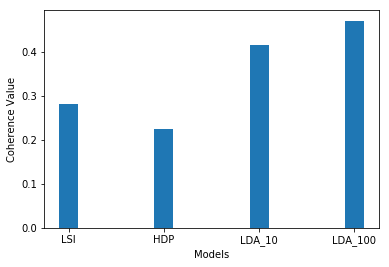

In [59]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_10_coherence,lda_100_coherence],
                   ['LSI', 'HDP', 'LDA_10', 'LDA_100'])

## Conclusion

Using evaluation techniques We are able to say if a model is objectively good or bad, and compare different models to each other. But as we can see it is difficult to evaluate topic models with most of the available tools. 

Topic coherennce gives the idea about how the bag of words in topic are co-herent but that doesnt give complete picture about topic.

# Further Improvements

 We can try to filter out general adjective and verbs from text and sample data randomly from different publications to get general picture. We can also tune hyperparameter and try with different number of epochs to get better topics. Further research should also include better evaluation technique that does job better than just evaluatng coherence.